# Sprint 13 - Projeto Final

### Tarefa

Segmente usuários com base em seus perfis de consumidor.

- Realize a análise exploratória de dados.
- Segmente os usuários com base no histórico de compras. Sinta-se à vontade para implementar suas próprias ideias para segmentar usuários. Pense em como a segmentação pode ajudar você a desenvolver ofertas mais personalizadas para diferentes usuários. Tente formar segmentos com base no que os usuários compram. Você pode analisar suas compras e segmentar as mercadorias de acordo com a categoria de produto a que pertencem.
- Formule e teste hipóteses estatísticas.

### **Descrição dos dados**

O conjunto de dados contém o histórico de transações da Everything Plus, uma loja online que vende utensílios domésticos.

O arquivo `ecommerce_dataset_us.csv` contém as seguintes colunas:

`InvoiceNo` — identificador de pedido

`StockCode` — identificador de item

`Description` — nome de item

`Quantity`

`InvoiceDate` — data do pedido

`UnitPrice` — preço por item

`CustomerID`

Faça uma lista de 5 a 10 fontes (documentação, artigos) que você usou enquanto trabalhava no projeto. Forneça breves explicações sobre as perguntas que cada fonte o ajudou a responder. Prepare uma apresentação com suas conclusões. Você pode usar qualquer ferramenta que desejar para fazer a apresentação, mas deve enviá-la em PDF. Coloque o link no corpo do projeto principal.

### Dashboards

1. Sugestão 1
    1. Faça um diagrama para o número de compras por dia
    2. Adicione um indicador para o número de clientes
    3. Adicione um filtro de data de compra
2. Sugestão 2
    1. Faça um diagrama para o total de compras por dia
    2. Trace um histograma de totais de compras individuais
    3. Adicione um filtro de data de compra

## Tratamento dos dados

In [116]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt


In [117]:
ecommerce = pd.read_csv('dataset/ecommerce_dataset_us.csv')

In [118]:
ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    65535 non-null  object 
 1   StockCode    65535 non-null  object 
 2   Description  65372 non-null  object 
 3   Quantity     65535 non-null  int64  
 4   InvoiceDate  65535 non-null  object 
 5   UnitPrice    65535 non-null  float64
 6   CustomerID   41231 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.5+ MB


- Atributos para arrumar
    - Alterar o nome das colunas para snake-case e tudo em letras minusculas
    - Remover valores nulos em customer_id da tabela já que não me permitem criar um perfil de cliente;
    - Alterar o tipo de dados de invoice_date para datetime;
    - Remover da tabela valores que estão negativos na coluna 'quantity';
    - Conferir e tratar os dados da coluna 'unit_price' se necessário;
    - Adicionar uma coluna com total gasto por usuário (total_spent)

In [119]:
# Renomear as colunas para que correspondam a Snake-Case e que tudo fique em letra minuscula
new_column_names = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id']

ecommerce.rename(columns=dict(zip(ecommerce.columns, new_column_names)), inplace=True)

In [120]:
print(ecommerce.head())

  invoice_no stock_code                     description  quantity  \
0    C541433      23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   
1     541431      23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   
4     537626      22726      ALARM CLOCK BAKELIKE GREEN         4   

       invoice_date  unit_price  customer_id  
0  01/16/2019 10:17        1.04      12346.0  
1  01/16/2019 10:01        1.04      12346.0  
2  12/05/2018 14:57        4.95      12347.0  
3  12/05/2018 14:57        3.75      12347.0  
4  12/05/2018 14:57        3.75      12347.0  


In [121]:
# Tratar os dados da coluna customer_id
ecommerce_clean = ecommerce[~ecommerce['customer_id'].isna()]

In [122]:
ecommerce_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41231 entries, 0 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    41231 non-null  object 
 1   stock_code    41231 non-null  object 
 2   description   41231 non-null  object 
 3   quantity      41231 non-null  int64  
 4   invoice_date  41231 non-null  object 
 5   unit_price    41231 non-null  float64
 6   customer_id   41231 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.5+ MB


In [123]:
# Atualizar o formato de dados de 'customer_id' para int
ecommerce_clean['customer_id'] = ecommerce_clean['customer_id'].astype('int')

C:\Users\renan\AppData\Local\Temp\ipykernel_14564\2181993322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean['customer_id'] = ecommerce_clean['customer_id'].astype('int')


### Tratando os dados da coluna 'quantity'

In [124]:
# Filtrando os dados para remover valores negativos de 'quantity' selecionando apenas valores maiores ou iguais a 1

ecommerce_clean = ecommerce_clean[ecommerce_clean['quantity']>= 1]

In [125]:
ecommerce_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40172 entries, 1 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    40172 non-null  object 
 1   stock_code    40172 non-null  object 
 2   description   40172 non-null  object 
 3   quantity      40172 non-null  int64  
 4   invoice_date  40172 non-null  object 
 5   unit_price    40172 non-null  float64
 6   customer_id   40172 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 2.3+ MB


In [126]:
# Alterar o tipo de dados de 'invoice_date' para datetime

ecommerce_clean['invoice_date'] = pd.to_datetime(ecommerce_clean['invoice_date'])

In [127]:
print(ecommerce_clean.head(3))

  invoice_no stock_code                     description  quantity  \
1     541431      23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   

         invoice_date  unit_price  customer_id  
1 2019-01-16 10:01:00        1.04        12346  
2 2018-12-05 14:57:00        4.95        12347  
3 2018-12-05 14:57:00        3.75        12347  


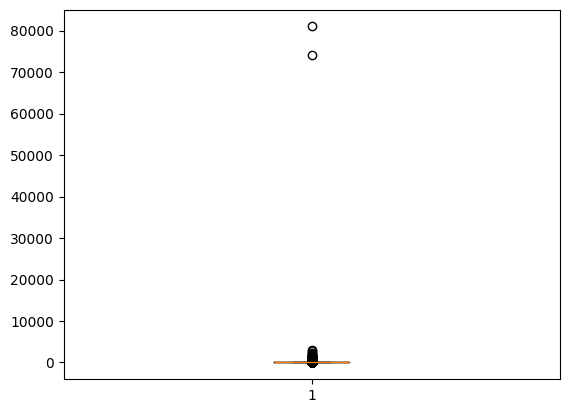

In [128]:
# Conferir os dados de quantidade pois parece ter alguns valores extremos

quantity_values = ecommerce_clean['quantity']

plt.boxplot(quantity_values)
plt.show()

In [129]:
# Filtrar os dados para remover dados de 'quantity' acima de 10000

ecommerce_clean = ecommerce_clean[ecommerce_clean['quantity']<=10000]

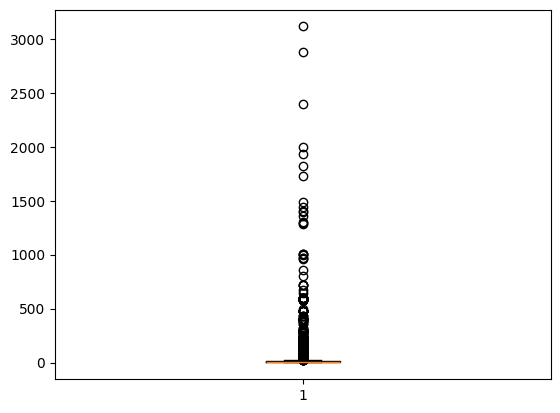

In [130]:
# Conferir os dados de quantidade após remoção

quantity_values_2 = ecommerce_clean['quantity']

plt.boxplot(quantity_values_2)
plt.show()

In [131]:
''' Acredito que tenha algo de errado com esses dados com valores acima de 1000 itens do mesmo pedido
    Estou pensando em agrupar por usuário e pedido e ver o máximo de produtos pedidos'''

group_user_orders = ecommerce_clean.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_user_orders.head(20))

customer_id  description                         unit_price
15749        FAIRY CAKE FLANNEL ASSORTED COLOUR  2.10          3114
16754        WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.18          2880
16029        GROW A FLYTRAP OR SUNFLOWER IN TIN  0.94          2400
15749        GIN + TONIC DIET METAL SIGN         1.85          2000
             WHITE HANGING HEART T-LIGHT HOLDER  2.55          1930
15299        ASSORTED COLOUR T-LIGHT HOLDER      0.55          1824
12875        ASSORTED LAQUERED INCENSE HOLDERS   0.17          1728
12755        ROUND SNACK BOXES SET OF 4 FRUITS   2.55          1488
14156        ASSORTED INCENSE PACK               0.16          1440
16754        RED  HARMONICA IN BOX               1.06          1400
17857        MINI PAINT SET VINTAGE              0.55          1394
17450        HEART OF WICKER SMALL               1.93          1356
15749        TEA TIME TEA TOWELS                 2.55          1300
17306        PACK OF 12 LONDON TISSUES           0.25   

- Com essa informação vejo que alguns dados os pedidos provavelmente estão errados, sendo assim vou filtrar o dataframe para quantidade superior e inferior a 300 pedidos e ver o resultado nos dados

In [132]:
# Filtrando as quantidades com limite de 300

above_300 = ecommerce_clean[ecommerce_clean['quantity'] >= 300]
below_300 = ecommerce_clean[ecommerce_clean['quantity'] < 300]

In [133]:
above_300.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 479 to 40054
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    89 non-null     object        
 1   stock_code    89 non-null     object        
 2   description   89 non-null     object        
 3   quantity      89 non-null     int64         
 4   invoice_date  89 non-null     datetime64[ns]
 5   unit_price    89 non-null     float64       
 6   customer_id   89 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 5.2+ KB


In [134]:
below_300.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40081 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    40081 non-null  object        
 1   stock_code    40081 non-null  object        
 2   description   40081 non-null  object        
 3   quantity      40081 non-null  int64         
 4   invoice_date  40081 non-null  datetime64[ns]
 5   unit_price    40081 non-null  float64       
 6   customer_id   40081 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.3+ MB


In [135]:
# Conferir a lista com os valores máximos até 300 pedidos

group_below_300 = below_300.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_below_300.head(20))

customer_id  description                         unit_price
14156        JAM MAKING SET PRINTED              1.25          288
17404        TEA BAG PLATE RED RETROSPOT         0.85          288
16210        POTTERING MUG                       0.42          288
14646        ASSORTED EASTER DECORATIONS  BELLS  1.06          288
             PLASTERS IN TIN WOODLAND ANIMALS    1.45          288
             5 HOOK HANGER RED MAGIC TOADSTOOL   1.45          288
14156        SET/5 RED SPOTTY LID GLASS BOWLS    2.55          288
13225        CHOCOLATE 3 WICK MORRIS BOX CANDLE  1.25          288
17511        DISCO BALL CHRISTMAS DECORATION     0.10          288
14156        PACK OF 20 NAPKINS RED APPLES       0.64          288
17511        FELT FARM ANIMAL WHITE BUNNY        0.19          288
14646        PACK OF 12 TRADITIONAL CRAYONS      0.36          288
16684        FANCY FONT BIRTHDAY CARD            0.36          288
14646        SET/10 BLUE POLKADOT PARTY CANDLES  1.06          288
18

- Olhando os produtos posso dizer que mesmo filtrando os pedidos com quantidade inferior a 300, ainda temos produtos com valores que não aparentam ser adequados para esses tipos de produtos.
- É necessário realizar novo tratamento desses dados e aplicar outra filtragem, nesse caso trabalharei com 100 itens

In [136]:
# Filtrando as quantidades com limite de 100

above_100 = ecommerce_clean[ecommerce_clean['quantity'] >= 100]
below_100 = ecommerce_clean[ecommerce_clean['quantity'] < 100]

In [137]:
above_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621 entries, 45 to 40644
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    621 non-null    object        
 1   stock_code    621 non-null    object        
 2   description   621 non-null    object        
 3   quantity      621 non-null    int64         
 4   invoice_date  621 non-null    datetime64[ns]
 5   unit_price    621 non-null    float64       
 6   customer_id   621 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 36.4+ KB


In [138]:
below_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39549 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    39549 non-null  object        
 1   stock_code    39549 non-null  object        
 2   description   39549 non-null  object        
 3   quantity      39549 non-null  int64         
 4   invoice_date  39549 non-null  datetime64[ns]
 5   unit_price    39549 non-null  float64       
 6   customer_id   39549 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.3+ MB


In [139]:
# Conferir a lista com os valores máximos até 100 pedidos

group_below_100 = below_100.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_below_100.head(20))

customer_id  description                          unit_price
13798        SET/6 RED SPOTTY PAPER PLATES        0.64          96
17324        BLUE POLKADOT PLATE                  1.45          96
16210        HAND WARMER UNION JACK               1.85          96
15061        SET 7 BABUSHKA NESTING BOXES         7.65          96
13082        PACK OF 12 SUKI TISSUES              0.29          96
14060        SET OF 20 VINTAGE CHRISTMAS NAPKINS  0.64          96
16210        HAND WARMER RED RETROSPOT            1.85          96
13798        LARGE CAKE TOWEL PINK SPOTS          1.95          96
16684        SMALL GLASS HEART TRINKET POT        1.85          96
14062        HAND WARMER BABUSHKA DESIGN          0.85          96
17324        BLUE POLKADOT CUP                    0.72          96
15311        RED STRIPE CERAMIC DRAWER KNOB       1.06          96
17324        PINK  POLKADOT CUP                   0.72          96
14646        SWISS ROLL TOWEL  PINK  SPOTS        1.25          96
1

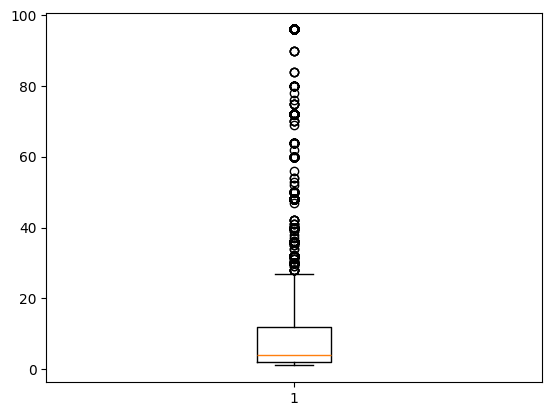

In [140]:
# Plotar histograma de quantidade inferior a 100

quant_below_100 = below_100['quantity']

plt.boxplot(quant_below_100)
plt.show()

- Com base neste novo boxplot é possível ver a distribuição dos dados onde temos o limite superior próximo a 20.
    - O passo agora é calcular esse limite, realizar nova filtragem dos dados e observar se vale a pena manter a nova filtragem ou utilizar os dados com quantidade abaixo de 100

In [141]:
''' Observação para mim mesmo, eu poderia ter realizado isso logo após confeccionar o primeiro boxplot ao invés de ficar adivinhando valores'''

# Calcular o limite superior do boxplot

# Calcular o terceiro quartil
q3 = below_100['quantity'].quantile(0.75)

# Calcular o primeiro quartil
q1 = below_100['quantity'].quantile(0.25)

# Calcular o intervalo interquartil (IQR)
iqr = q3-q1

# Calcular o limite superior
upper_limit = q3 + 1.5 * iqr

print("O limite superior é: ", upper_limit)

O limite superior é:  27.0


- Como descobri que o limite superior é de 27, vou realizar a filtragem dos dados para 'quantity' até 27 e depois estudar os dados

In [142]:
# Filtrando os dados para quantity até 27
below_27 = ecommerce_clean[ecommerce_clean['quantity'] <= 27]

In [143]:
below_27.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37483 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    37483 non-null  object        
 1   stock_code    37483 non-null  object        
 2   description   37483 non-null  object        
 3   quantity      37483 non-null  int64         
 4   invoice_date  37483 non-null  datetime64[ns]
 5   unit_price    37483 non-null  float64       
 6   customer_id   37483 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.1+ MB


In [144]:
# Conferindo o total de usuários únicos após a filtragem

unique_users_27 = below_27['customer_id'].nunique()

print(unique_users_27)

1680


- Com base nos resultados obtidos temos 1680 usuários únicos no novo dataframe filtrado

### Estudando a coluna 'unit_price'

- Antes de mais nada, vou criar renomear o dataframe 'below_27' para 'ecommerce_clean_27' assim entendo de onde vieram esses dados já que eles foram limpos uma vez e filtrados.

In [145]:
# Renomeando o Dataframe para trabalho

ecommerce_clean_27 = below_27

In [149]:
# Conferir a lista com os valores máximos até 100 pedidos

group_unit_price = ecommerce_clean_27.groupby(['description','quantity'])['unit_price'].max().sort_values(ascending=False)
print(group_unit_price.head(20))

description                         quantity
VINTAGE RED KITCHEN CABINET         1           295.00
LOVE SEAT ANTIQUE WHITE METAL       2           175.00
RUSTIC  SEVENTEEN DRAWER SIDEBOARD  1           165.00
REGENCY MIRROR WITH SHUTTERS        1           165.00
CARRIAGE                            1           150.00
RUSTIC  SEVENTEEN DRAWER SIDEBOARD  2           145.00
CHEST NATURAL WOOD 20 DRAWERS       1           125.00
VINTAGE BLUE KITCHEN CABINET        1           125.00
                                    2           125.00
VINTAGE RED KITCHEN CABINET         2           125.00
CHEST NATURAL WOOD 20 DRAWERS       4           110.00
VINTAGE POST OFFICE CABINET         1            79.95
SCHOOL DESK AND CHAIR               1            65.00
                                    2            65.00
VINTAGE POST OFFICE CABINET         10           52.77
HALL CABINET WITH 3 DRAWERS         1            49.95
PINK PAINTED KASHMIRI CHAIR         4            42.95
POSTAGE             

- Observando os preços dos itens, os mesmos parecem de acordo com os itens em questão.

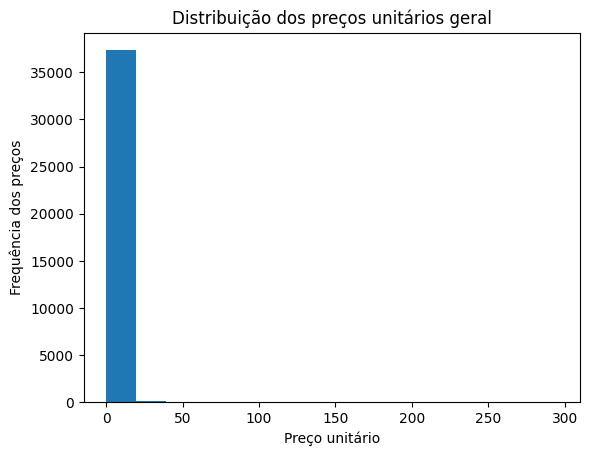

In [157]:
# Histograma da distribuição dos preços
plt.hist(ecommerce_clean_27['unit_price'], bins=15)
plt.ylabel('Frequência dos preços')
plt.xlabel('Preço unitário')
plt.title('Distribuição dos preços unitários geral')
plt.show()

- O histograma nos mostra que a grande maioria dos preços unitários dos produtos se encontra entre zero e 25.

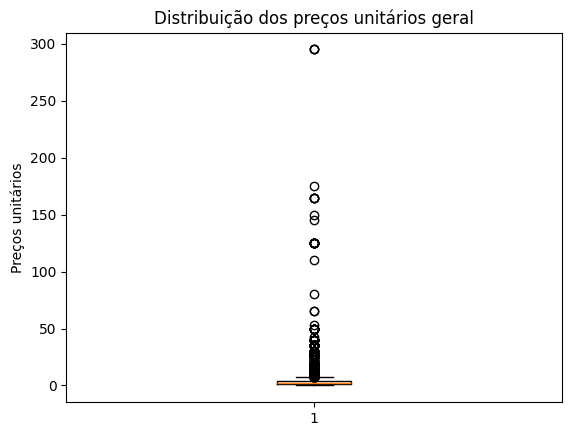

In [159]:
# Boxplot da distribuição dos preços
plt.boxplot(ecommerce_clean_27['unit_price'])
plt.ylabel('Preços unitários')
plt.title('Distribuição dos preços unitários geral')
plt.show()

- Com o boxplot dos preços unitarios podemos ver que há vários produtos com valores outliers justificados pelo tipo de produto em si.

### Criar uma coluna com o valor total gasto por usuário

In [162]:
ecommerce_clean_27['total_spent'] = (ecommerce_clean_27['unit_price'] * ecommerce_clean_27['quantity'])

C:\Users\renan\AppData\Local\Temp\ipykernel_14564\3784831467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean_27['total_spent'] = (ecommerce_clean_27['unit_price'] * ecommerce_clean_27['quantity'])


In [163]:
print(ecommerce_clean_27.head())

  invoice_no stock_code                     description  quantity  \
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   
4     537626      22726      ALARM CLOCK BAKELIKE GREEN         4   
5     537626      22727       ALARM CLOCK BAKELIKE RED          4   
6     537626      22728       ALARM CLOCK BAKELIKE PINK         4   

         invoice_date  unit_price  customer_id  total_expent  total_spent  
2 2018-12-05 14:57:00        4.95        12347         14.85        14.85  
3 2018-12-05 14:57:00        3.75        12347         15.00        15.00  
4 2018-12-05 14:57:00        3.75        12347         15.00        15.00  
5 2018-12-05 14:57:00        3.75        12347         15.00        15.00  
6 2018-12-05 14:57:00        3.75        12347         15.00        15.00  
